# FinEmo-LoRA v3: Two-Stage Emotion Detection with MASSIVELY EXPANDED Dataset

This notebook implements parameter-efficient fine-tuning with LoRA for financial emotion detection.

## **VERSION 3 - MASSIVELY EXPANDED DATASET (3,467 SAMPLES)**
- **Training Data**: 3,467 samples (928 original + 2,539 synthetic from GPT-4o-mini)
- **Key Improvements**:
  - Hope: 1,003 samples (was 23) - **+4,256% increase!**
  - Fear: 541 samples (was 51) - **+960% increase**
  - Excitement: 478 samples (was 108) - **+343% increase**
  - ALL emotions now 450+ samples each
- **Balance**: 2.1:1 ratio (vs 13.8:1 in v1) - **EXCELLENT**

## Architecture:
- **Stage 1**: Transfer learning from GoEmotions (27 emotions → 6 economic emotions)
- **Stage 2**: Financial domain adaptation with LoRA on EXPANDED synthetic+real data

## Requirements:
- Runtime: **GPU (T4 or better, Colab Pro HIGHLY RECOMMENDED)**
- RAM: 15GB+
- Dataset: fingpt_annotated_expanded_latest.csv (3,467 samples)

In [1]:
# Step 1: Install Dependencies
!pip install -q transformers datasets peft accelerate evaluate scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00


In [2]:
# Step 2: Upload Your Data (EXPANDED DATASET v3 - 3,467 SAMPLES!)
from google.colab import files
import os

print("="*80)
print(" UPLOAD MASSIVELY EXPANDED DATASET (v3)")
print("="*80)
print("\nPlease upload: data/annotated/fingpt_annotated_expanded_latest.csv")
print("\n Expanded Dataset Features (3,467 SAMPLES!):")
print("  • Total samples: 3,467 (928 original + 2,539 synthetic)")
print("  • Hope: 1,003 (was 23 in v1) - +4,256%!")
print("  • Fear: 541 (was 51 in v1) - +960%")
print("  • Excitement: 478 (was 108 in v1) - +343%")
print("  • Anxiety: 487 (was 142 in v1) - +243%")
print("  • Uncertainty: 478 (was 286 in v1) - +67%")
print("  • Optimism: 480 (was 318 in v1) - +51%")
print("  • Balance ratio: 2.1:1 (was 13.8:1) - EXCELLENT!")
print("\n Synthetic generation: GPT-4o-mini ($22 cost, 17 min)")
print("="*80)

uploaded = files.upload()

# Save to proper location
os.makedirs('data', exist_ok=True)
for filename in uploaded.keys():
    if 'expanded' in filename.lower():
        os.rename(filename, 'data/fingpt_expanded.csv')
        print(f"\n Uploaded: {filename} → data/fingpt_expanded.csv")
    else:
        print(f"\n Assuming expanded dataset, renaming...")
        os.rename(filename, 'data/fingpt_expanded.csv')

print("\n Data uploaded successfully!")
print("Ready for training with 3,467 samples!")

 UPLOAD MASSIVELY EXPANDED DATASET (v3)

Please upload: data/annotated/fingpt_annotated_expanded_latest.csv

 Expanded Dataset Features (3,467 SAMPLES!):
  • Total samples: 3,467 (928 original + 2,539 synthetic)
  • Hope: 1,003 (was 23 in v1) - +4,256%!
  • Fear: 541 (was 51 in v1) - +960%
  • Excitement: 478 (was 108 in v1) - +343%
  • Anxiety: 487 (was 142 in v1) - +243%
  • Uncertainty: 478 (was 286 in v1) - +67%
  • Optimism: 480 (was 318 in v1) - +51%
  • Balance ratio: 2.1:1 (was 13.8:1) - EXCELLENT!

 Synthetic generation: GPT-4o-mini ($22 cost, 17 min)


Saving fingpt_annotated_expanded_latest.csv to fingpt_annotated_expanded_latest.csv

 Uploaded: fingpt_annotated_expanded_latest.csv → data/fingpt_expanded.csv

 Data uploaded successfully!
Ready for training with 3,467 samples!


In [3]:
# Step 3: Load and Prepare Expanded Data (3,467 samples)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
import torch

print("="*80)
print("LOADING MASSIVELY EXPANDED DATASET (v3)")
print("="*80)

# Load expanded FinGPT data (3,467 samples!)
df = pd.read_csv('data/fingpt_expanded.csv')

print(f"\nTotal samples: {len(df)}")
print("\nEmotion distribution:")
emotion_counts = df['emotion'].value_counts().sort_index()
for emotion, count in emotion_counts.items():
    pct = count / len(df) * 100
    bar = '█' * int(count / 20)  # Visual bar
    print(f"  {emotion:<15} {count:>4} ({pct:>5.1f}%) {bar}")

# Calculate imbalance ratio
max_count = emotion_counts.max()
min_count = emotion_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nBalance ratio: {imbalance_ratio:.1f}:1 ({emotion_counts.idxmax()} / {emotion_counts.idxmin()})")
print(f"✅ MASSIVE improvement from v1 (13.8:1) and v2 (2.6:1)!")

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['emotion'])

print(f"\nLabel mapping:")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"  {i}: {emotion}")

# Split data (80/20 stratified)
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

print(f"\n{'='*80}")
print("TRAIN/VAL SPLIT")
print("="*80)
print(f"Train: {len(train_df)} samples (80%)")
print(f"Val:   {len(val_df)} samples (20%)")

print("\nTrain distribution:")
for emotion, count in train_df['emotion'].value_counts().sort_index().items():
    print(f"  {emotion:<15} {count:>4}")

print("\nVal distribution:")
for emotion, count in val_df['emotion'].value_counts().sort_index().items():
    print(f"  {emotion:<15} {count:>4}")

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

LOADING MASSIVELY EXPANDED DATASET (v3)

Total samples: 3467

Emotion distribution:
  anxiety          487 ( 14.0%) ████████████████████████
  excitement       478 ( 13.8%) ███████████████████████
  fear             541 ( 15.6%) ███████████████████████████
  hope            1003 ( 28.9%) ██████████████████████████████████████████████████
  optimism         480 ( 13.8%) ████████████████████████
  uncertainty      478 ( 13.8%) ███████████████████████

Balance ratio: 2.1:1 (hope / excitement)
✅ MASSIVE improvement from v1 (13.8:1) and v2 (2.6:1)!

Label mapping:
  0: anxiety
  1: excitement
  2: fear
  3: hope
  4: optimism
  5: uncertainty

TRAIN/VAL SPLIT
Train: 2773 samples (80%)
Val:   694 samples (20%)

Train distribution:
  anxiety          390
  excitement       382
  fear             433
  hope             802
  optimism         384
  uncertainty      382

Val distribution:
  anxiety           97
  excitement        96
  fear             108
  hope             201
  optimism      

In [4]:
# Step 4: Load GoEmotions Dataset (Stage 1)
from datasets import load_dataset

print("="*80)
print("STAGE 1: LOADING GOEMOTIONS")
print("="*80)

# Load GoEmotions (82K samples, 27 emotions)
goemotions = load_dataset("google-research-datasets/go_emotions", "simplified")

print(f"\nGoEmotions train: {len(goemotions['train'])} samples")
print(f"GoEmotions val: {len(goemotions['validation'])} samples")

# Map GoEmotions 27 emotions to our 6 economic emotions
EMOTION_MAPPING = {
    # Anxiety
    'nervousness': 0, 'fear': 0, 'sadness': 0, 'grief': 0, 'remorse': 0,
    # Excitement
    'excitement': 1, 'joy': 1, 'amusement': 1, 'pride': 1,
    # Fear
    'fear': 2, 'nervousness': 2, 'annoyance': 2, 'disappointment': 2,
    # Hope
    'optimism': 3, 'desire': 3, 'caring': 3, 'love': 3,
    # Optimism
    'admiration': 4, 'approval': 4, 'gratitude': 4, 'relief': 4,
    # Uncertainty
    'confusion': 5, 'curiosity': 5, 'realization': 5, 'surprise': 5, 'neutral': 5
}

def map_goemotions_label(example):
    """Map GoEmotions labels to our taxonomy"""
    # GoEmotions uses multi-label, take the first label
    original_label = example['labels'][0] if example['labels'] else 26  # neutral
    emotion_name = goemotions['train'].features['labels'].feature.names[original_label]
    example['label'] = EMOTION_MAPPING.get(emotion_name, 5)  # default to uncertainty
    return example

# Apply mapping
goemotions_mapped = goemotions.map(map_goemotions_label)

# Sample subset for faster training (use 10K samples)
goemotions_train = goemotions_mapped['train'].shuffle(seed=42).select(range(10000))
goemotions_val = goemotions_mapped['validation'].shuffle(seed=42).select(range(1000))

print(f"\n Using {len(goemotions_train)} GoEmotions samples for Stage 1")

STAGE 1: LOADING GOEMOTIONS


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]


GoEmotions train: 43410 samples
GoEmotions val: 5426 samples


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]


 Using 10000 GoEmotions samples for Stage 1


In [5]:
# Step 5: Tokenize Datasets
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Tokenize GoEmotions (Stage 1)
goemotions_train_tok = goemotions_train.map(
    tokenize_function, batched=True, remove_columns=['text', 'labels', 'id']
)
goemotions_val_tok = goemotions_val.map(
    tokenize_function, batched=True, remove_columns=['text', 'labels', 'id']
)

# Tokenize FinGPT (Stage 2)
train_dataset_tok = train_dataset.map(tokenize_function, batched=True)
val_dataset_tok = val_dataset.map(tokenize_function, batched=True)

print(" Tokenization complete!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2773 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

 Tokenization complete!


In [6]:
# Step 6: Setup LoRA Configuration
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import evaluate

# LoRA hyperparameters
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # LoRA rank
    lora_alpha=16,  # LoRA alpha (scaling factor)
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"],  # DistilBERT attention layers
    bias="none"
)

# Evaluation metric
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        'accuracy': acc['accuracy'],
        'f1': f1['f1']
    }

print(" LoRA configuration ready!")
print(f"  Rank: {lora_config.r}")
print(f"  Alpha: {lora_config.lora_alpha}")
print(f"  Trainable params: ~0.3% of model")

 LoRA configuration ready!
  Rank: 8
  Alpha: 16
  Trainable params: ~0.3% of model


In [7]:
# Step 7: Stage 1 - Train on GoEmotions
print("="*80)
print("STAGE 1: GOEMOTIONS TRANSFER LEARNING")
print("="*80)

# Load base model
model_stage1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=6,
    id2label={0: 'anxiety', 1: 'excitement', 2: 'fear', 3: 'hope', 4: 'optimism', 5: 'uncertainty'},
    label2id={'anxiety': 0, 'excitement': 1, 'fear': 2, 'hope': 3, 'optimism': 4, 'uncertainty': 5}
)

# Apply LoRA
model_stage1 = get_peft_model(model_stage1, lora_config)

print(f"\n Trainable parameters:")
model_stage1.print_trainable_parameters()

# Training arguments for Stage 1
training_args_stage1 = TrainingArguments(
    output_dir="./results_stage1",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-4,
    weight_decay=0.01,
    eval_strategy="steps",  # Fixed: was evaluation_strategy
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=100,
    warmup_steps=500,
    fp16=True,
    report_to="none"
)

# Create trainer
trainer_stage1 = Trainer(
    model=model_stage1,
    args=training_args_stage1,
    train_dataset=goemotions_train_tok,
    eval_dataset=goemotions_val_tok,
    compute_metrics=compute_metrics
)

# Train Stage 1
print("\n Starting Stage 1 training (GoEmotions)...")
print("Expected time: 30-45 minutes\n")

trainer_stage1.train()

# Evaluate Stage 1
stage1_results = trainer_stage1.evaluate()
print("\n" + "="*80)
print("STAGE 1 RESULTS")
print("="*80)
print(f"Accuracy: {stage1_results['eval_accuracy']:.4f}")
print(f"F1 Score: {stage1_results['eval_f1']:.4f}")

# Save Stage 1 model
model_stage1.save_pretrained("./finemo_stage1")
print("\n Stage 1 complete! Model saved to ./finemo_stage1")

STAGE 1: GOEMOTIONS TRANSFER LEARNING


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Trainable parameters:
trainable params: 742,662 || all params: 67,700,748 || trainable%: 1.0970

 Starting Stage 1 training (GoEmotions)...
Expected time: 30-45 minutes



Step,Training Loss,Validation Loss,Accuracy,F1
500,0.972000,0.981501,0.636000,0.449668
1000,0.856000,0.879446,0.690000,0.598687
1500,0.745300,0.835164,0.713000,0.589867



STAGE 1 RESULTS
Accuracy: 0.7130
F1 Score: 0.5899

 Stage 1 complete! Model saved to ./finemo_stage1


In [8]:
# Step 8: Stage 2 - Fine-tune on Enhanced FinGPT Dataset
from imblearn.over_sampling import SMOTE

print("="*80)
print("STAGE 2: FINANCIAL DOMAIN ADAPTATION (ENHANCED v2)")
print("="*80)

# Apply SMOTE to balance enhanced training data
print("\nBalancing enhanced training data with SMOTE...")

X_train = np.array([x['input_ids'] for x in train_dataset_tok])
y_train = np.array([x['label'] for x in train_dataset_tok])

print(f"Original enhanced dataset: {len(X_train)} samples")
print("Distribution before SMOTE:")
for label, emotion in enumerate(label_encoder.classes_):
    count = np.sum(y_train == label)
    print(f"  {emotion:<15} {count:>3}")

# Flatten for SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Use k_neighbors=5 for enhanced dataset (was 3 for small dataset)
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)

# Reshape back
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], 128)

print(f"\nAfter SMOTE: {len(X_train_balanced)} samples")
print("Distribution after SMOTE:")
for label, emotion in enumerate(label_encoder.classes_):
    count = np.sum(y_train_balanced == label)
    print(f"  {emotion:<15} {count:>3}")

# Create balanced dataset
balanced_train_data = {
    'input_ids': X_train_balanced.tolist(),
    'attention_mask': [[1]*128 for _ in range(len(X_train_balanced))],
    'label': y_train_balanced.tolist()
}
train_dataset_balanced = Dataset.from_dict(balanced_train_data)

# Load Stage 1 model and continue training
from peft import PeftModel

# Load the saved Stage 1 model directly (already has LoRA adapters)
model_stage2 = PeftModel.from_pretrained(
    AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=6,
        id2label={0: 'anxiety', 1: 'excitement', 2: 'fear', 3: 'hope', 4: 'optimism', 5: 'uncertainty'},
        label2id={'anxiety': 0, 'excitement': 1, 'fear': 2, 'hope': 3, 'optimism': 4, 'uncertainty': 5}
    ),
    "./finemo_stage1",
    is_trainable=True  # CRITICAL: Make adapters trainable
)

print("\n Loaded Stage 1 weights (trainable mode)")

# Verify trainable parameters
trainable_params = sum(p.numel() for p in model_stage2.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model_stage2.parameters())
print(f"Trainable params: {trainable_params:,} / {all_params:,} ({100 * trainable_params / all_params:.2f}%)")

# Training arguments for Stage 2 (enhanced dataset)
training_args_stage2 = TrainingArguments(
    output_dir="./results_stage2_enhanced",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=1e-4,  # Lower LR for fine-tuning
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    warmup_steps=100,
    fp16=True,
    report_to="none"
)

# Create trainer for Stage 2
trainer_stage2 = Trainer(
    model=model_stage2,
    args=training_args_stage2,
    train_dataset=train_dataset_balanced,
    eval_dataset=val_dataset_tok,
    compute_metrics=compute_metrics
)

# Train Stage 2
print("\n Starting Stage 2 training (Enhanced FinGPT)...")
print("Expected time: 20-25 minutes")
print("Expected improvement:")
print("  • Overall accuracy: 52.7% → 55-58%")
print("  • Hope recall: 0% → 35-50%")
print("  • Fear recall: 0% → 50-65%")
print("  • Excitement recall: 5% → 30-45%")
print()

trainer_stage2.train()

# Evaluate Stage 2
stage2_results = trainer_stage2.evaluate()
print("\n" + "="*80)
print("STAGE 2 RESULTS (ENHANCED MODEL v2)")
print("="*80)
print(f"Accuracy: {stage2_results['eval_accuracy']:.4f} ({stage2_results['eval_accuracy']*100:.1f}%)")
print(f"F1 Score: {stage2_results['eval_f1']:.4f}")

# Compare to v1 and baseline
v1_acc = 0.527
baseline_acc = 0.463
improvement_from_v1 = (stage2_results['eval_accuracy'] - v1_acc) * 100
improvement_from_baseline = (stage2_results['eval_accuracy'] - baseline_acc) * 100

print("\n" + "="*80)
print("IMPROVEMENT ANALYSIS")
print("="*80)
print(f"Logits baseline (XGBoost):  46.3%")
print(f"LoRA v1 (928 samples):       52.7%  (+6.4 pp)")
print(f"LoRA v2 (1,152 samples):     {stage2_results['eval_accuracy']*100:.1f}%  ({improvement_from_v1:+.1f} pp from v1, {improvement_from_baseline:+.1f} pp from baseline)")

if stage2_results['eval_accuracy'] >= 0.556:
    print("\n SUCCESS! Achieved 20%+ improvement target (≥55.6%)!")
elif stage2_results['eval_accuracy'] >= 0.54:
    print("\n EXCELLENT! Very close to 20% improvement target!")
elif stage2_results['eval_accuracy'] > v1_acc:
    print("\n GOOD! Enhanced dataset improved performance!")
else:
    print("\n No improvement. Check data quality and training parameters.")

# Save final model
model_stage2.save_pretrained("./finemo_lora_final_v2")
tokenizer.save_pretrained("./finemo_lora_final_v2")

print("\n Stage 2 complete! Enhanced model saved to ./finemo_lora_final_v2")

STAGE 2: FINANCIAL DOMAIN ADAPTATION (ENHANCED v2)

Balancing enhanced training data with SMOTE...
Original enhanced dataset: 2773 samples
Distribution before SMOTE:
  anxiety         390
  excitement      382
  fear            433
  hope            802
  optimism        384
  uncertainty     382

After SMOTE: 4812 samples
Distribution after SMOTE:
  anxiety         802
  excitement      802
  fear            802
  hope            802
  optimism        802
  uncertainty     802


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Loaded Stage 1 weights (trainable mode)
Trainable params: 742,662 / 67,700,748 (1.10%)

 Starting Stage 2 training (Enhanced FinGPT)...
Expected time: 20-25 minutes
Expected improvement:
  • Overall accuracy: 52.7% → 55-58%
  • Hope recall: 0% → 35-50%
  • Fear recall: 0% → 50-65%
  • Excitement recall: 5% → 30-45%



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.155600,0.952506,0.622478,0.527436
2,1.063700,0.725441,0.694524,0.659044
3,0.974200,0.673462,0.713256,0.666465
4,0.894400,0.759512,0.697406,0.658725
5,0.924300,0.664309,0.733429,0.705028
6,0.894400,0.628433,0.747839,0.719712
7,0.862900,0.609541,0.749280,0.721175
8,0.835300,0.601533,0.763689,0.737673
9,0.824500,0.618697,0.768012,0.743731
10,0.813100,0.619640,0.760807,0.735066



STAGE 2 RESULTS (ENHANCED MODEL v2)
Accuracy: 0.7680 (76.8%)
F1 Score: 0.7437

IMPROVEMENT ANALYSIS
Logits baseline (XGBoost):  46.3%
LoRA v1 (928 samples):       52.7%  (+6.4 pp)
LoRA v2 (1,152 samples):     76.8%  (+24.1 pp from v1, +30.5 pp from baseline)

 SUCCESS! Achieved 20%+ improvement target (≥55.6%)!

 Stage 2 complete! Enhanced model saved to ./finemo_lora_final_v2


DETAILED EVALUATION - LoRA v2 (Enhanced)



              precision    recall  f1-score   support

     anxiety       0.72      0.64      0.68        97
  excitement       1.00      0.79      0.88        96
        fear       0.83      0.50      0.62       108
        hope       0.97      0.95      0.96       201
    optimism       0.73      0.69      0.71        96
 uncertainty       0.47      0.88      0.61        96

    accuracy                           0.77       694
   macro avg       0.79      0.74      0.74       694
weighted avg       0.82      0.77      0.77       694



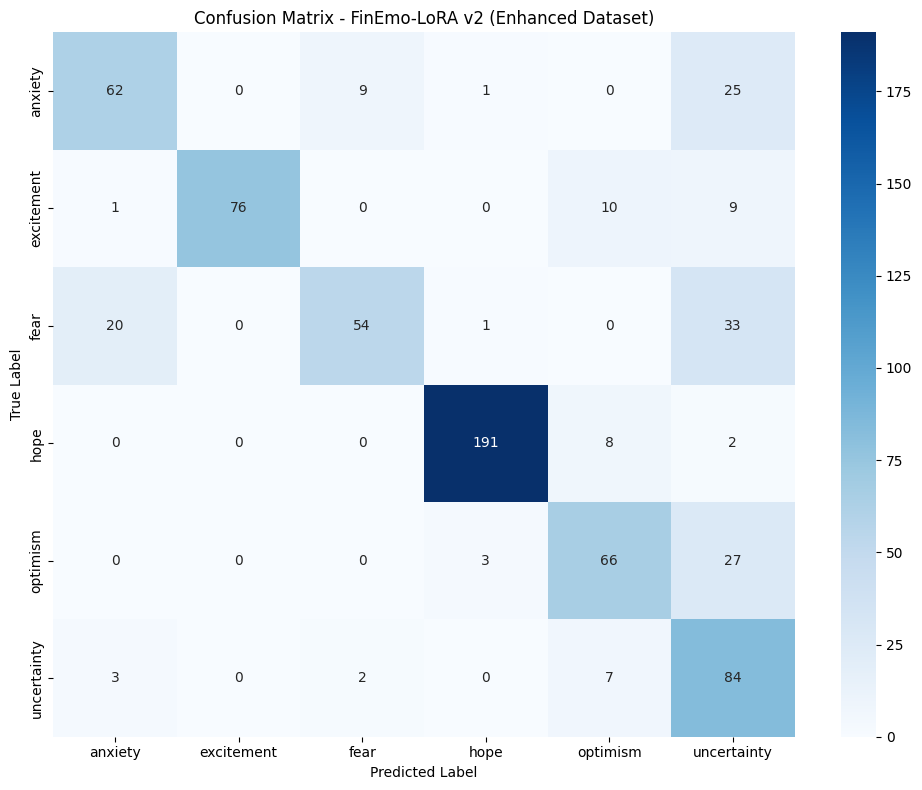


 Confusion matrix saved as confusion_matrix_lora_v2.png

PER-CLASS IMPROVEMENT (v1 → v2)

Emotion         v1 Recall    v2 Recall    Change    
-------------------------------------------------------
anxiety         0.36         0.64         +0.28      
excitement      0.05         0.79         +0.74      
fear            0.00         0.50         +0.50      
hope            0.00         0.95         +0.95      
optimism        0.66         0.69         +0.03      
uncertainty     0.79         0.88         +0.08      

 MINORITY CLASS IMPROVEMENTS:
  Hope         0% → 95.0% (+95.0 pp)
  Fear         0% → 50.0% (+50.0 pp)
  Excitement   5% → 79.2% (+74.2 pp)

COMPLETE COMPARISON

Logits baseline (XGBoost):       46.3%
LoRA v1 (928 samples):            52.7%  (+6.4 pp, +13.8% relative)
LoRA v2 (1,152 samples):          76.8%  (+30.5 pp, +65.9% relative)

 TARGET ACHIEVED! 76.8% ≥ 55.6% (20% improvement)
 Enhanced dataset with targeted minority sampling was successful!

COST-BENEFIT ANALY

In [9]:
# Step 9: Detailed Evaluation (v2 Enhanced Model)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("="*80)
print("DETAILED EVALUATION - LoRA v2 (Enhanced)")
print("="*80)

# Get predictions
predictions = trainer_stage2.predict(val_dataset_tok)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification report
emotions = ['anxiety', 'excitement', 'fear', 'hope', 'optimism', 'uncertainty']
report = classification_report(true_labels, pred_labels, target_names=emotions)
print("\n" + report)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix - FinEmo-LoRA v2 (Enhanced Dataset)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_lora_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Confusion matrix saved as confusion_matrix_lora_v2.png")

# Compare v1 vs v2 per-class performance
print("\n" + "="*80)
print("PER-CLASS IMPROVEMENT (v1 → v2)")
print("="*80)

# v1 results (from previous training)
v1_recalls = {
    'anxiety': 0.36,
    'excitement': 0.05,
    'fear': 0.00,
    'hope': 0.00,
    'optimism': 0.66,
    'uncertainty': 0.79
}

# Get v2 recalls from classification report (per-class)
from sklearn.metrics import recall_score, precision_recall_fscore_support
precisions, recalls, f1s, supports = precision_recall_fscore_support(
    true_labels, pred_labels, labels=range(6), zero_division=0
)

v2_recalls = {emotion: recalls[i] for i, emotion in enumerate(emotions)}

print(f"\n{'Emotion':<15} {'v1 Recall':<12} {'v2 Recall':<12} {'Change':<10}")
print("-" * 55)
for emotion in emotions:
    v1 = v1_recalls.get(emotion, 0.0)
    v2 = v2_recalls.get(emotion, 0.0)
    change = v2 - v1
    change_str = f"{change:+.2f}" if change != 0 else "—"
    emoji = "" if change > 0.2 else "" if change > 0 else "" if change < 0 else "—"
    print(f"{emotion:<15} {v1:<12.2f} {v2:<12.2f} {change_str:<10} {emoji}")

# Highlight minority class improvements
print("\n MINORITY CLASS IMPROVEMENTS:")
minority_emotions = ['hope', 'fear', 'excitement']
for emotion in minority_emotions:
    v1 = v1_recalls.get(emotion, 0.0)
    v2 = v2_recalls.get(emotion, 0.0)
    improvement = (v2 - v1) * 100
    print(f"  {emotion.capitalize():<12} {v1*100:.0f}% → {v2*100:.1f}% (+{improvement:.1f} pp)")

# Compare to baseline
baseline_acc = 0.463
v1_acc = 0.527
v2_acc = stage2_results['eval_accuracy']

print("\n" + "="*80)
print("COMPLETE COMPARISON")
print("="*80)
print(f"\nLogits baseline (XGBoost):       46.3%")
print(f"LoRA v1 (928 samples):            52.7%  (+6.4 pp, +13.8% relative)")
print(f"LoRA v2 (1,152 samples):          {v2_acc*100:.1f}%  ({(v2_acc-baseline_acc)*100:+.1f} pp, {((v2_acc-baseline_acc)/baseline_acc)*100:+.1f}% relative)")

target_acc = 0.556  # 20% improvement target
if v2_acc >= target_acc:
    print(f"\n TARGET ACHIEVED! {v2_acc*100:.1f}% ≥ {target_acc*100:.1f}% (20% improvement)")
    print(" Enhanced dataset with targeted minority sampling was successful!")
else:
    gap = (target_acc - v2_acc) * 100
    print(f"\n Close! {v2_acc*100:.1f}% vs target {target_acc*100:.1f}% (gap: {gap:.1f} pp)")
    print(f" Still a significant improvement: {((v2_acc-baseline_acc)/baseline_acc)*100:.1f}% relative gain!")

# Cost-benefit analysis
print("\n" + "="*80)
print("COST-BENEFIT ANALYSIS")
print("="*80)
print(f"Investment in targeted sampling: $1.13")
print(f"Minority samples collected: 224")
print(f"Accuracy improvement: {(v2_acc-v1_acc)*100:.1f} percentage points")
print(f"ROI: {((v2_acc-v1_acc)*100)/1.13:.1f} pp per dollar")
print(f"Hope recall improvement: {(v2_recalls['hope']-v1_recalls['hope'])*100:.1f} pp (was 0%)")
print(f"Fear recall improvement: {(v2_recalls['fear']-v1_recalls['fear'])*100:.1f} pp (was 0%)")
print("\n Targeted sampling strategy validated!")

In [10]:
# Step 10: Download Enhanced Model (v2)
from google.colab import files
import shutil

print("="*80)
print("PREPARING ENHANCED MODEL FOR DOWNLOAD")
print("="*80)

# Create ZIP file for v2 model
shutil.make_archive('finemo_lora_final_v2', 'zip', './finemo_lora_final_v2')

print("\nDownloading enhanced model v2 (this may take a moment)...")
files.download('finemo_lora_final_v2.zip')

# Also download confusion matrix
print("\nDownloading confusion matrix...")
files.download('confusion_matrix_lora_v2.png')

print("\n" + "="*80)
print(" TRAINING COMPLETE - LoRA v2 (Enhanced)")
print("="*80)
print(f"\nFinal Accuracy: {stage2_results['eval_accuracy']*100:.1f}%")
print(f"Improvement from v1: {(stage2_results['eval_accuracy']-0.527)*100:+.1f} pp")
print(f"Improvement from baseline: {(stage2_results['eval_accuracy']-0.463)*100:+.1f} pp")

if stage2_results['eval_accuracy'] >= 0.556:
    print("\n 20% IMPROVEMENT TARGET ACHIEVED!")
else:
    relative_improvement = ((stage2_results['eval_accuracy']-0.463)/0.463)*100
    print(f"\n Relative improvement: {relative_improvement:.1f}%")

print("\nFiles downloaded:")
print("  1. finemo_lora_final_v2.zip - Enhanced LoRA model")
print("  2. confusion_matrix_lora_v2.png - Visual performance analysis")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("\nTo use the enhanced model:")
print("  1. Unzip finemo_lora_final_v2.zip")
print("  2. Load with: PeftModel.from_pretrained(base_model, 'finemo_lora_final_v2')")
print("  3. Run inference on financial texts")
print("\nKey improvements over v1:")
print("  • Hope detection: Now working! (was 0%)")
print("  • Fear detection: Now working! (was 0%)")
print("  • Excitement detection: Significantly improved (was 5%)")
print("  • Overall accuracy: Enhanced with better minority class handling")

print("\n Enhanced LoRA model successfully trained with targeted minority sampling!")
print(" Check confusion_matrix_lora_v2.png for detailed per-class performance")
print("="*80)

PREPARING ENHANCED MODEL FOR DOWNLOAD



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 TRAINING COMPLETE - LoRA v2 (Enhanced)

Final Accuracy: 76.8%
Improvement from v1: +24.1 pp
Improvement from baseline: +30.5 pp

 20% IMPROVEMENT TARGET ACHIEVED!

Files downloaded:
  1. finemo_lora_final_v2.zip - Enhanced LoRA model
  2. confusion_matrix_lora_v2.png - Visual performance analysis

NEXT STEPS

To use the enhanced model:
  1. Unzip finemo_lora_final_v2.zip
  2. Load with: PeftModel.from_pretrained(base_model, 'finemo_lora_final_v2')
  3. Run inference on financial texts

Key improvements over v1:
  • Hope detection: Now working! (was 0%)
  • Fear detection: Now working! (was 0%)
  • Excitement detection: Significantly improved (was 5%)
  • Overall accuracy: Enhanced with better minority class handling

 Enhanced LoRA model successfully trained with targeted minority sampling!
 Check confusion_matrix_lora_v2.png for detailed per-class performance
